# The idea

I have an idea for my variability spreadsheet code (an idea that may be more eloquent and panda-onic (like pythonic?) than my NamedTuples approach): using the approach advocated [here](https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns/47103408).

I'm curious whether I can make it work.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(np.random.rand(4,4), columns=list('abcd'))
df['group'] = [0, 0, 1, 1]
df

,a,b,c,d,group
0,0.248995,0.213058,0.065458,0.782586,0
1,0.749441,0.031997,0.745567,0.169574,0
2,0.729009,0.715107,0.055130,0.755678,1
3,0.589078,0.827124,0.251792,0.048393,1


In [2]:
df.groupby('group').agg({'a':['sum', 'max'], 
                         'b':'mean', 
                         'c':'sum', 
                         'd': lambda x: x.max() - x.min()})

a                   b         c         d
            sum       max      mean       sum  <lambda>
group                                                  
0      0.998436  0.749441  0.122527  0.811025  0.613012
1      1.318087  0.729009  0.771116  0.306922  0.707284

In [3]:
def max_min(x):
    return x.max() - x.min()

max_min.__name__ = 'Max minus Min'

df.groupby('group').agg({'a':['sum', 'max'], 
                         'b':'mean', 
                         'c':'sum', 
                         'd': max_min})

a                   b         c             d
            sum       max      mean       sum Max minus Min
group                                                      
0      0.998436  0.749441  0.122527  0.811025      0.613012
1      1.318087  0.729009  0.771116  0.306922      0.707284

In [4]:
def f(x):
    d = {}
    d['a_sum'] = x['a'].sum()
    d['a_max'] = x['a'].max()
    d['b_mean'] = x['b'].mean()
    d['c_d_prodsum'] = (x['c'] * x['d']).sum()
    return pd.Series(d, index=['a_sum', 'a_max', 'b_mean', 'c_d_prodsum'])

df.groupby('group').apply(f)

,a_sum,a_max,b_mean,c_d_prodsum
group,,,,
0,0.998436,0.749441,0.122527,0.177656
1,1.318087,0.729009,0.771116,0.053846


In [5]:
def f_mi(x):
    d = []
    d.append(x['a'].sum())
    d.append(x['a'].max())
    d.append(x['b'].mean())
    d.append((x['c'] * x['d']).sum())
    return pd.Series(d, index=[['a', 'a', 'b', 'c_d'], 
                               ['sum', 'max', 'mean', 'prodsum']])

multi_groupby = df.groupby('group').apply(f_mi)
multi_groupby

a                   b       c_d
            sum       max      mean   prodsum
group                                        
0      0.998436  0.749441  0.122527  0.177656
1      1.318087  0.729009  0.771116  0.053846

In [6]:
multi_groupby['a']['max']

group
0    0.749441
1    0.729009
Name: max, dtype: float64

okay, so what if we had like... 3 types of variables (J, H, K), and we wanted to do mean, median, min, max, range, ... let's try it with mean/median/std for J and H following the syntax they've got:

In [7]:
from astropy.table import Table

dat = Table.read('/Users/tsrice/Desktop/Academia/Variability_Data_2019/WSERV8_results6_23_50_28_30335.fits', format='fits')
dat['JAPERMAG3ERR'] = (1.082 * dat['JAPERMAG3ERR']**2 + 0.021**2)**0.5
dat['HAPERMAG3ERR'] = (1.082 * dat['HAPERMAG3ERR']**2 + 0.021**2)**0.5
dat['KAPERMAG3ERR'] = (1.082 * dat['KAPERMAG3ERR']**2 + 0.021**2)**0.5

sentinel_value = -999999488.0
for column in dat.columns:
    if (dat[column].dtype == '>f8') or (dat[column].dtype == '>f4'):
        nulls = [dat[column] == sentinel_value]
        print(f"column {column} has {np.sum(nulls)} nulls")
        dat[column][dat[column] == sentinel_value] = np.nan

dat_subset = dat[(
    (dat['JAPERMAG3'] < 15) & (dat['JAPERMAG3'] > 12) &
    (dat['HAPERMAG3'] < 15) & (dat['HAPERMAG3'] > 12) &
    (dat['KAPERMAG3'] < 15) & (dat['KAPERMAG3'] > 12))]

df = dat_subset.to_pandas()


column MEANMJDOBS has 0 nulls
column RA has 0 nulls
column DEC has 0 nulls
column JMHPNT has 612740 nulls
column JMHPNTERR has 612740 nulls
column HMKPNT has 435914 nulls
column HMKPNTERR has 435914 nulls
column JAPERMAG3 has 541266 nulls
column HAPERMAG3 has 276269 nulls
column KAPERMAG3 has 212267 nulls
column PSTAR has 0 nulls


/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


In [8]:
# just a quick test of this, 
df.groupby('SOURCEID').apply(np.mean)

,SOURCEID,MEANMJDOBS,RA,DEC,JMHPNT,JMHPNTERR,HMKPNT,HMKPNTERR,JAPERMAG3,JAPERMAG3ERR,HAPERMAG3,HAPERMAG3ERR,KAPERMAG3,KAPERMAG3ERR,JPPERRBITS,HPPERRBITS,KPPERRBITS,MERGEDCLASS,PSTAR
SOURCEID,,,,,,,,,,,,,,,,,,,
44989782425721,4.498978e+13,57003.594106,0.979962,0.557381,1.361630,0.005828,0.649881,0.003527,14.555218,0.021754,13.193588,0.021166,12.543706,0.021192,1.864135e+06,1.864135e+06,1.864135e+06,-0.930556,0.913138
44989782425735,4.498978e+13,57001.936794,0.979933,0.557236,1.020441,0.004121,0.544448,0.002980,13.868609,0.021346,12.848168,0.021107,12.303720,0.021146,5.178232e+04,5.178232e+04,5.178252e+04,-0.962963,0.949658
44989782425791,4.498978e+13,56934.767008,0.979842,0.558070,1.109156,0.004126,0.740727,0.002895,13.883900,0.021333,12.774744,0.021109,12.034017,0.021112,0.000000e+00,0.000000e+00,1.600000e+01,-1.000000,0.999657
44989782425814,4.498978e+13,56999.041061,0.979795,0.555419,0.778374,0.006810,0.358536,0.006033,14.680937,0.021856,13.902563,0.021373,13.544027,0.021697,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,0.999657
44989782425822,4.498978e+13,56999.041061,0.979771,0.556952,0.892081,0.003998,0.472549,0.003108,13.778776,0.021314,12.886695,0.021111,12.414146,0.021165,0.000000e+00,0.000000e+00,0.000000e+00,-0.987500,0.980936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44989782508839,4.498978e+13,56995.947112,0.974881,0.569705,0.531913,0.004332,0.202026,0.004307,13.766907,0.021326,13.234994,0.021179,13.032968,0.021361,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,0.999002
44989782508848,4.498978e+13,56995.995047,0.975422,0.569721,0.848346,0.006796,0.475791,0.005480,14.610311,0.021900,13.761965,0.021359,13.286174,0.021496,0.000000e+00,0.000000e+00,0.000000e+00,-0.987730,0.991482
44989782508898,4.498978e+13,56995.947112,0.974298,0.569791,0.865747,0.006466,0.283858,0.005612,14.565766,0.021809,13.700019,0.021317,13.416161,0.021611,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,0.998346


In [9]:
J = 'JAPERMAG3'
H = 'HAPERMAG3'
K = 'KAPERMAG3'
J_e = 'JAPERMAG3ERR'
H_e = 'HAPERMAG3ERR'
K_e = 'KAPERMAG3ERR'

function_list = [
    np.nanmean, 
    np.nanmedian, 
    np.nanmin, 
    np.nanmax, 
    np.nanstd, 
    lambda x: np.nanmax(x) - np.nanmin(x)]

function_names = ['mean', 'median', 'min', 'max', 'std', 'range']

def f_mi(x):
    d = []
    top_index = []
    bottom_index = []
    for fn, fn_name in zip(function_list, function_names):
        for band in [J, H, K]:
            d.append(fn(x[band]))
            top_index.append(band)
            bottom_index.append(fn_name)
    return pd.Series(d, index=[bottom_index, top_index])

df_multi_groupby = df.groupby('SOURCEID').apply(f_mi)
df_multi_groupby

mean                           median             \
                JAPERMAG3  HAPERMAG3  KAPERMAG3  JAPERMAG3  HAPERMAG3   
SOURCEID                                                                
44989782425721  14.555217  13.193587  12.543706  14.536730  13.184750   
44989782425735  13.868610  12.848167  12.303720  13.853812  12.837662   
44989782425791  13.883901  12.774745  12.034017  13.799045  12.724780   
44989782425814  14.680937  13.902562  13.544027  14.683567  13.901947   
44989782425822  13.778775  12.886694  12.414146  13.776497  12.886608   
...                   ...        ...        ...        ...        ...   
44989782508839  13.766907  13.234996  13.032970  13.766114  13.234081   
44989782508848  14.610312  13.761965  13.286175  14.610989  13.757499   
44989782508898  14.565765  13.700018  13.416161  14.567413  13.698818   
44989782508925  14.553364  13.903010  13.639818  14.554184  13.901673   
44989782508976  13.936830  13.153639  12.884085  13.940843  13.160633   

                                 min                              max  \
                KAPERMAG3  JAPERMAG3  HAPERMAG3  KAPERMAG3  JAPERMAG3   
SOURCEID                                                                
44989782425721  12.534737  14.418927  13.017068  12.483096  14.932868   
44989782425735  12.286799  13.827968  12.800623  12.268824  14.916791   
44989782425791  12.025903  13.785515  12.704490  12.007247  14.067141   
44989782425814  13.544539  14.625485  13.874234  13.493191  14.706351   
44989782425822  12.412338  13.758884  12.851735  12.398381  13.842829   
...                   ...        ...        ...        ...        ...   
44989782508839  13.032776  13.735806  13.200852  12.983247  13.831981   
44989782508848  13.286608  14.500193  13.704712  13.230235  14.693098   
44989782508898  13.415350  14.534244  13.678200  13.379236  14.601549   
44989782508925  13.636993  14.451966  13.877941  13.582266  14.615354   
44989782508976  12.887240  13.684727  12.972191  12.737350  14.156644   

                                           std                         range  \
                HAPERMAG3  KAPERMAG3 JAPERMAG3 HAPERMAG3 KAPERMAG3 JAPERMAG3   
SOURCEID                                                                       
44989782425721  13.386883  12.905150  0.075553  0.042368  0.042815  0.513941   
44989782425735  13.753282  13.071846  0.118116  0.101920  0.099291  1.088823   
44989782425791  12.894962  12.068902  0.129688  0.085410  0.025816  0.281626   
44989782425814  13.932762  13.572303  0.012699  0.010048  0.012031  0.080866   
44989782425822  12.925612  12.476804  0.012424  0.010543  0.010036  0.083944   
...                   ...        ...       ...       ...       ...       ...   
44989782508839  13.270697  13.096808  0.013733  0.011924  0.015813  0.096174   
44989782508848  13.847474  13.349839  0.019589  0.022775  0.015386  0.192905   
44989782508898  13.726524  13.455703  0.012278  0.008964  0.012856  0.067306   
44989782508925  13.950692  14.025195  0.018384  0.014961  0.045200  0.163387   
44989782508976  13.212469  13.052186  0.072281  0.037058  0.042289  0.471917   

                                    
               HAPERMAG3 KAPERMAG3  
SOURCEID                            
44989782425721  0.369815  0.422054  
44989782425735  0.952659  0.803022  
44989782425791  0.190473  0.061655  
44989782425814  0.058528  0.079112  
44989782425822  0.073877  0.078423  
...                  ...       ...  
44989782508839  0.069844  0.113562  
44989782508848  0.142762  0.119604  
44989782508898  0.048325  0.076467  
44989782508925  0.072751  0.442929  
44989782508976  0.240278  0.314836  

[1015 rows x 18 columns]

In [10]:
df_multi_groupby['mean']

,JAPERMAG3,HAPERMAG3,KAPERMAG3
SOURCEID,,,
44989782425721,14.555217,13.193587,12.543706
44989782425735,13.868610,12.848167,12.303720
44989782425791,13.883901,12.774745,12.034017
44989782425814,14.680937,13.902562,13.544027
44989782425822,13.778775,12.886694,12.414146
...,...,...,...
44989782508839,13.766907,13.234996,13.032970
44989782508848,14.610312,13.761965,13.286175
44989782508898,14.565765,13.700018,13.416161


In [11]:
df.columns

Index(['SOURCEID', 'MEANMJDOBS', 'RA', 'DEC', 'JMHPNT', 'JMHPNTERR', 'HMKPNT',
       'HMKPNTERR', 'JAPERMAG3', 'JAPERMAG3ERR', 'HAPERMAG3', 'HAPERMAG3ERR',
       'KAPERMAG3', 'KAPERMAG3ERR', 'JPPERRBITS', 'HPPERRBITS', 'KPPERRBITS',
       'MERGEDCLASS', 'PSTAR'],
      dtype='object')

In [12]:
for col in df.columns:
    print(col)

SOURCEID
MEANMJDOBS
RA
DEC
JMHPNT
JMHPNTERR
HMKPNT
HMKPNTERR
JAPERMAG3
JAPERMAG3ERR
HAPERMAG3
HAPERMAG3ERR
KAPERMAG3
KAPERMAG3ERR
JPPERRBITS
HPPERRBITS
KPPERRBITS
MERGEDCLASS
PSTAR


In [13]:
count_functions = [
    lambda x, y: np.sum(~np.isnan(x)),
    lambda x, y: np.sum(~np.isnan(x[y == 0])),
    lambda x, y: np.sum(~np.isnan(x[(0 < y) & (y < 256)])),
    lambda x, y: np.sum(~np.isnan(x[(256 <= y) & (y < 65536)])),
    lambda x, y: np.sum(~np.isnan(x[y >= 65536])),
]

bands = ["J", "H", "K"]
count_names = [
    lambda x: f"N_{x}",
    lambda x: f"N_{x}_good",
    lambda x: f"N_{x}_info",
    lambda x: f"N_{x}_warn",
    lambda x: f"N_{x}_severe",
]


def f_mi_inclusive(x):
    d = []
    primary_index = []
    secondary_index = []
    for fn, fn_name in zip(function_list, function_names):
        for column in df.columns[1:]:
            d.append(fn(x[column]))
            primary_index.append(fn_name)
            secondary_index.append(column)
    for fn, fn_name in zip(count_functions, count_names):
        for band in bands:
            d.append(fn(x[f"{band}APERMAG3"], x[f"{band}PPERRBITS"]))
            primary_index.append("count")
            secondary_index.append(fn_name(band))    
    return pd.Series(d, index=[primary_index, secondary_index])

df_multi_groupby_inclusive = df.groupby('SOURCEID').apply(f_mi_inclusive)
df_multi_groupby_inclusive

mean                                          \
                  MEANMJDOBS        RA       DEC    JMHPNT JMHPNTERR   
SOURCEID                                                               
44989782425721  57003.594106  0.979962  0.557381  1.361630  0.005828   
44989782425735  57001.936794  0.979933  0.557236  1.020441  0.004121   
44989782425791  56934.767008  0.979842  0.558070  1.109156  0.004126   
44989782425814  56999.041061  0.979795  0.555419  0.778374  0.006810   
44989782425822  56999.041061  0.979771  0.556952  0.892081  0.003998   
...                      ...       ...       ...       ...       ...   
44989782508839  56995.947112  0.974881  0.569705  0.531913  0.004332   
44989782508848  56995.995047  0.975422  0.569721  0.848346  0.006796   
44989782508898  56995.947112  0.974298  0.569791  0.865747  0.006466   
44989782508925  56995.947112  0.970990  0.569813  0.650353  0.006753   
44989782508976  57003.258213  0.972366  0.569914  0.783193  0.004539   

                                                                       ...  \
                  HMKPNT HMKPNTERR  JAPERMAG3 JAPERMAG3ERR  HAPERMAG3  ...   
SOURCEID                                                               ...   
44989782425721  0.649881  0.003527  14.555217     0.021754  13.193587  ...   
44989782425735  0.544448  0.002980  13.868610     0.021346  12.848167  ...   
44989782425791  0.740727  0.002895  13.883901     0.021333  12.774745  ...   
44989782425814  0.358536  0.006033  14.680937     0.021856  13.902562  ...   
44989782425822  0.472549  0.003108  13.778775     0.021314  12.886694  ...   
...                  ...       ...        ...          ...        ...  ...   
44989782508839  0.202026  0.004307  13.766907     0.021326  13.234996  ...   
44989782508848  0.475791  0.005480  14.610312     0.021900  13.761965  ...   
44989782508898  0.283858  0.005612  14.565765     0.021809  13.700018  ...   
44989782508925  0.263193  0.006574  14.553364     0.021817  13.903010  ...   
44989782508976  0.269553  0.004055  13.936830     0.021391  13.153639  ...   

                  count                                                        \
               N_K_good N_J_info N_H_info N_K_info N_J_warn N_H_warn N_K_warn   
SOURCEID                                                                        
44989782425721     80.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782425735     79.0      0.0      0.0      1.0      0.0      0.0      0.0   
44989782425791      0.0      0.0      0.0      3.0      0.0      0.0      0.0   
44989782425814     80.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782425822     80.0      0.0      0.0      0.0      0.0      0.0      0.0   
...                 ...      ...      ...      ...      ...      ...      ...   
44989782508839     84.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782508848    163.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782508898     84.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782508925     83.0      0.0      0.0      1.0      0.0      0.0      0.0   
44989782508976      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

                                                 
               N_J_severe N_H_severe N_K_severe  
SOURCEID                                         
44989782425721       64.0       64.0       64.0  
44989782425735        1.0        1.0        1.0  
44989782425791        0.0        0.0        0.0  
44989782425814        0.0        0.0        0.0  
44989782425822        0.0        0.0        0.0  
...                   ...        ...        ...  
44989782508839        0.0        0.0        0.0  
44989782508848        0.0        0.0        0.0  
44989782508898        0.0        0.0        0.0  
44989782508925        0.0        0.0        0.0  
44989782508976       71.0       71.0       71.0  

[1015 rows x 123 columns]

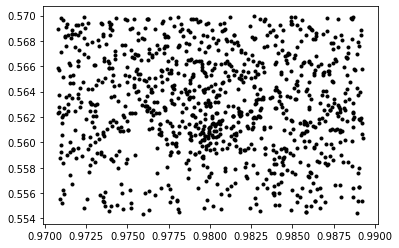

In [14]:
ds = df_multi_groupby_inclusive
plt.plot(ds['mean']['RA'], ds['mean']['DEC'], 'k.')

In [15]:
ds

mean                                          \
                  MEANMJDOBS        RA       DEC    JMHPNT JMHPNTERR   
SOURCEID                                                               
44989782425721  57003.594106  0.979962  0.557381  1.361630  0.005828   
44989782425735  57001.936794  0.979933  0.557236  1.020441  0.004121   
44989782425791  56934.767008  0.979842  0.558070  1.109156  0.004126   
44989782425814  56999.041061  0.979795  0.555419  0.778374  0.006810   
44989782425822  56999.041061  0.979771  0.556952  0.892081  0.003998   
...                      ...       ...       ...       ...       ...   
44989782508839  56995.947112  0.974881  0.569705  0.531913  0.004332   
44989782508848  56995.995047  0.975422  0.569721  0.848346  0.006796   
44989782508898  56995.947112  0.974298  0.569791  0.865747  0.006466   
44989782508925  56995.947112  0.970990  0.569813  0.650353  0.006753   
44989782508976  57003.258213  0.972366  0.569914  0.783193  0.004539   

                                                                       ...  \
                  HMKPNT HMKPNTERR  JAPERMAG3 JAPERMAG3ERR  HAPERMAG3  ...   
SOURCEID                                                               ...   
44989782425721  0.649881  0.003527  14.555217     0.021754  13.193587  ...   
44989782425735  0.544448  0.002980  13.868610     0.021346  12.848167  ...   
44989782425791  0.740727  0.002895  13.883901     0.021333  12.774745  ...   
44989782425814  0.358536  0.006033  14.680937     0.021856  13.902562  ...   
44989782425822  0.472549  0.003108  13.778775     0.021314  12.886694  ...   
...                  ...       ...        ...          ...        ...  ...   
44989782508839  0.202026  0.004307  13.766907     0.021326  13.234996  ...   
44989782508848  0.475791  0.005480  14.610312     0.021900  13.761965  ...   
44989782508898  0.283858  0.005612  14.565765     0.021809  13.700018  ...   
44989782508925  0.263193  0.006574  14.553364     0.021817  13.903010  ...   
44989782508976  0.269553  0.004055  13.936830     0.021391  13.153639  ...   

                  count                                                        \
               N_K_good N_J_info N_H_info N_K_info N_J_warn N_H_warn N_K_warn   
SOURCEID                                                                        
44989782425721     80.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782425735     79.0      0.0      0.0      1.0      0.0      0.0      0.0   
44989782425791      0.0      0.0      0.0      3.0      0.0      0.0      0.0   
44989782425814     80.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782425822     80.0      0.0      0.0      0.0      0.0      0.0      0.0   
...                 ...      ...      ...      ...      ...      ...      ...   
44989782508839     84.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782508848    163.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782508898     84.0      0.0      0.0      0.0      0.0      0.0      0.0   
44989782508925     83.0      0.0      0.0      1.0      0.0      0.0      0.0   
44989782508976      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

                                                 
               N_J_severe N_H_severe N_K_severe  
SOURCEID                                         
44989782425721       64.0       64.0       64.0  
44989782425735        1.0        1.0        1.0  
44989782425791        0.0        0.0        0.0  
44989782425814        0.0        0.0        0.0  
44989782425822        0.0        0.0        0.0  
...                   ...        ...        ...  
44989782508839        0.0        0.0        0.0  
44989782508848        0.0        0.0        0.0  
44989782508898        0.0        0.0        0.0  
44989782508925        0.0        0.0        0.0  
44989782508976       71.0       71.0       71.0  

[1015 rows x 123 columns]

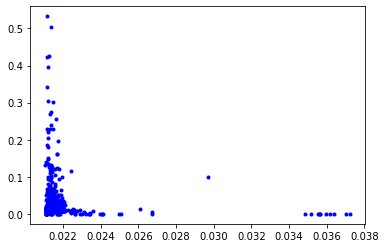

In [16]:
plt.plot(ds['median']['JAPERMAG3ERR'], ds['std']['JAPERMAG3'], 'b.')
# plt.plot([0,1], [0,1], lw=5, c='k', alpha=0.5, scalex=False, scaley=False)
xmax = ds['median']['JAPERMAG3ERR'].max()
# plt.xlim(0, xmax)
# plt.ylim(0, xmax)

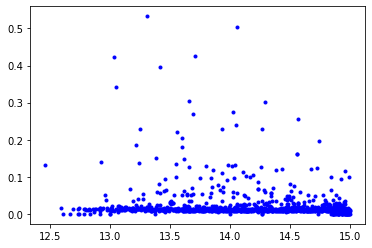

In [17]:
plt.plot(ds['median']['JAPERMAG3'], ds['std']['JAPERMAG3'], 'b.')

In [18]:
np.percentile(ds['median']['JAPERMAG3'], 90)

14.911437225341796

In [19]:
df

,SOURCEID,MEANMJDOBS,RA,DEC,JMHPNT,JMHPNTERR,HMKPNT,HMKPNTERR,JAPERMAG3,JAPERMAG3ERR,HAPERMAG3,HAPERMAG3ERR,KAPERMAG3,KAPERMAG3ERR,JPPERRBITS,HPPERRBITS,KPPERRBITS,MERGEDCLASS,PSTAR
0,44989782425721,56849.626177,0.979962,0.557381,1.381393,0.006078,0.630464,0.003720,14.553023,0.021777,13.171630,0.021160,12.541166,0.021195,0,0,0,-1,0.999657
1,44989782425721,56850.617897,0.979962,0.557381,1.336267,0.006159,0.666673,0.003428,14.532829,0.021799,13.196563,0.021162,12.529890,0.021139,0,0,0,-1,0.999657
2,44989782425721,56850.619583,0.979962,0.557381,1.527552,0.007540,0.758046,0.003798,14.914434,0.022242,13.386883,0.021185,12.628837,0.021185,4194304,4194304,4194304,0,0.000171
3,44989782425721,56855.629343,0.979962,0.557381,1.351305,0.004933,0.661070,0.002978,14.549131,0.021509,13.197826,0.021111,12.536757,0.021117,0,0,0,-1,0.944606
4,44989782425721,56855.630840,0.979962,0.557381,1.570897,0.005972,0.731744,0.003239,14.932868,0.021769,13.361971,0.021136,12.630227,0.021134,4194304,4194304,4194304,0,0.052478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78012,44989782508976,57053.238730,0.972366,0.569914,0.804606,0.003833,0.258830,0.003301,13.937800,0.021271,13.133194,0.021105,12.874364,0.021175,4194304,4194304,4194304,-1,0.999657
78013,44989782508976,57226.612790,0.972366,0.569914,0.780024,0.003992,0.285516,0.003563,13.940843,0.021286,13.160819,0.021122,12.875303,0.021203,4194304,4194304,4194304,-1,0.999657
78014,44989782508976,57227.597531,0.972366,0.569914,0.880294,0.004908,0.283852,0.003704,14.041646,0.021483,13.161352,0.021132,12.877501,0.021220,4194304,4194304,4194304,-1,0.999657
78015,44989782508976,57229.618985,0.972367,0.569914,0.808959,0.003976,0.249061,0.003639,13.945260,0.021285,13.136301,0.021120,12.887240,0.021220,4194304,4194304,4194304,-1,0.999657


In [20]:
df_multi_groupby_inclusive['count']

,N_J,N_H,N_K,N_J_good,N_H_good,N_K_good,N_J_info,N_H_info,N_K_info,N_J_warn,N_H_warn,N_K_warn,N_J_severe,N_H_severe,N_K_severe
SOURCEID,,,,,,,,,,,,,,,
44989782425721,144.0,144.0,144.0,80.0,80.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,64.0,64.0
44989782425735,81.0,81.0,81.0,80.0,80.0,79.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
44989782425791,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
44989782425814,80.0,80.0,80.0,80.0,80.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44989782425822,80.0,80.0,80.0,80.0,80.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44989782508839,84.0,84.0,84.0,84.0,84.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44989782508848,163.0,163.0,163.0,163.0,163.0,163.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44989782508898,84.0,84.0,84.0,84.0,84.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


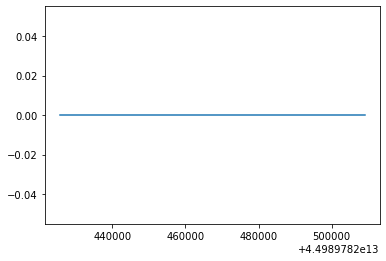

In [21]:
plt.plot(df_multi_groupby_inclusive['count']['N_J'] - df_multi_groupby_inclusive['count']['N_K'])